In [1]:
import sys
sys.dont_write_bytecode = True
import pandas as pd
import pickle
import bz2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import marshal
import time
import collections
import os

2023-11-30 10:17:49.693632: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 10:17:49.722293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 10:17:49.722317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 10:17:49.722335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 10:17:49.727840: I tensorflow/core/platform/cpu_feature_g

In [2]:
from docker_agent_logger.app.src.AI import *

Using TensorFlow backend


In [3]:
raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v1/HDFS.log")
    # .batch(128)
    # .shuffle(buffer_size=256)
)

2023-11-30 10:17:54.127875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [4]:
for i in raw_ds.take(1):
    print(i)

tf.Tensor(b'081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010', shape=(), dtype=string)


In [ ]:
for i in raw_ds.take(100):
    print(i)

In [ ]:
count = 0
for i in raw_ds.batch(128):
    count += 128

print(count)

In [ ]:
#get max len, mean len and std len excluding outliers (len > 1000)
seq_lens = []
for i in raw_ds:
    seq_lens.append(len(i.numpy()))
    if len(i.numpy()) > 1000:
        print(len(i.numpy()))

seq_lens = np.array(seq_lens)
print(seq_lens.max())
print(seq_lens.mean())
print(seq_lens.std())
print(seq_lens.min())
print(len(seq_lens))

In [9]:
vocab_size = 3000
max_len=60
epochs=32
chkpt = "docker_agent_logger/app/classifier_labeled/31"
MAN_TRAINING_SEQ_LEN = 1000

raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v1/HDFS.log")
    .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)

# vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
#             raw_ds,
#             vocabulary_size=vocab_size,
#             reserved_tokens=["[PAD]", "[UNK]", "[BOS]","[EOS]"],
#         )

# with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","wb") as f:
#     pickle.dump(vocab,f)

with open("docker_agent_logger/app/logs_tokenizer/vocab_labeled.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)


ds = raw_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)


val_split = 0.2
ds_size = 11175629

train_size = int((1-val_split) * ds_size)
val_size = int(val_split * ds_size)

train_ds = ds.take(train_size).shuffle(buffer_size=train_size).batch(128)
val_ds = raw_ds.skip(train_size).take(val_size)



model = Model(vocab_size = vocab_size,latent_dim=max_len//2,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt) #17 for the other model

# model.train_model(ds,epochs=epochs,chkpt=chkpt)






Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 60, 128)              391680    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 60, 128)              74398     ['input_embedding[0][0]']     
 er)                                                                                        

In [10]:
from docker_agent_reader.app.src.AI_rnd import *

In [12]:
for i in val_ds.take(1):
    print(i)

In [ ]:
with open("sample_logs.txt","w") as f:
    for logs in val_ds.take(50000).batch(1):
        f.write(logs.numpy()[0].decode("utf-8")+"\n")

In [8]:
percentile = 98
anomaly_detector = AnomalyDetector(latent_space_dim=max_len//2,threshold=np.inf)
data = {"logs":[],"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[]}
times = {"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[],"anomaly":[],"anomaly_rnd":[]}
recostruction_loss = []
recostruction_loss_rnd = []
d = collections.deque(maxlen=1000)
d_rnd = collections.deque(maxlen=1000)
thresholds = [np.inf,]
thresholds_rnd = [np.inf,]


for logs in val_ds.take(1000).batch(1):
    t = time.time()
    parsed_logs = tokenizer.parsing(logs)   
    t_parse = time.time()
    times["parsed_logs"].append(t_parse-t)
    vectorized_logs = tokenizer.vectorization(parsed_logs)
    t_vectorize = time.time()
    times["vectorized_logs"].append(t_vectorize-t_parse)
    encoded_logs = model.vae.encode(vectorized_logs)
    t_encode = time.time()
    times["encoded_logs"].append(t_encode-t_vectorize)
    losses = model.vae.train_step(vectorized_logs,train=False)


    anomaly = False
    if losses["reconstruction_loss"].numpy() > thresholds[-1]:
        anomaly = True
        # print(f"anomaly detected with a reconstruction loss of {losses['reconstruction_loss'].numpy()}")

    d.append(losses["reconstruction_loss"].numpy())
    thresholds.append(np.percentile(d,percentile))
    
    t_anomaly = time.time()
    times["anomaly"].append(t_anomaly-t_encode)

    recostruction_loss_rnd_value, anomaly_rnd = anomaly_detector.detect(encoded_logs,thresholds_rnd[-1])

    if anomaly_rnd:
        print(f"anomaly detected with a reconstruction loss of {recostruction_loss_rnd_value.numpy()}")
        print(logs.numpy()[0].decode("utf-8"))

    d_rnd.append(recostruction_loss_rnd_value.numpy())
    thresholds_rnd.append(np.percentile(d_rnd,percentile))
    

    times["anomaly_rnd"].append(time.time()-t_anomaly)

    anomaly_detector.train_step(encoded_logs)


    recostruction_loss_rnd.append(recostruction_loss_rnd_value.numpy())
    recostruction_loss.append(losses["reconstruction_loss"].numpy())
    compressed_data = bz2.compress(pickle.dumps(logs))
    data["logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(parsed_logs))
    data["parsed_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(vectorized_logs))
    data["vectorized_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(encoded_logs))
    data["encoded_logs"].append(sys.getsizeof(compressed_data))

Model: "fixed_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_4 (Dense)             (None, 128)               3968      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
Total params: 20480 (80.00 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20480 (80.00 KB)
_________________________________________________________________
Model: "trainable_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                            

In [9]:
data

{'logs': [], 'parsed_logs': [], 'vectorized_logs': [], 'encoded_logs': []}

In [10]:
times

{'parsed_logs': [],
 'vectorized_logs': [],
 'encoded_logs': [],
 'anomaly': [],
 'anomaly_rnd': []}

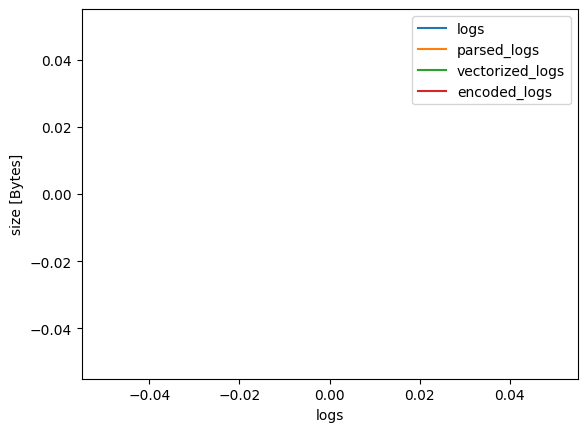

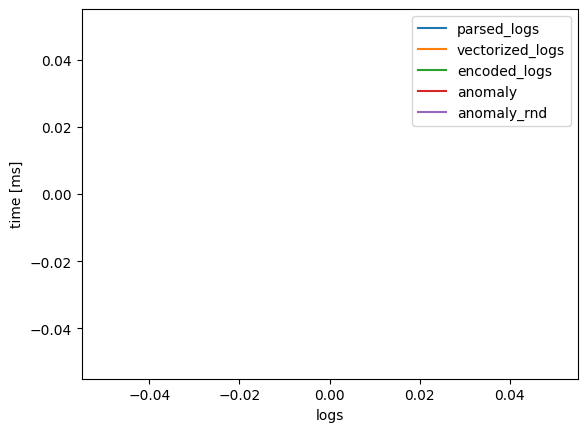

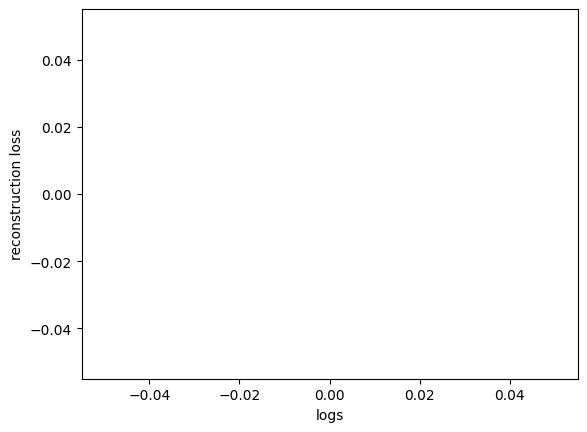

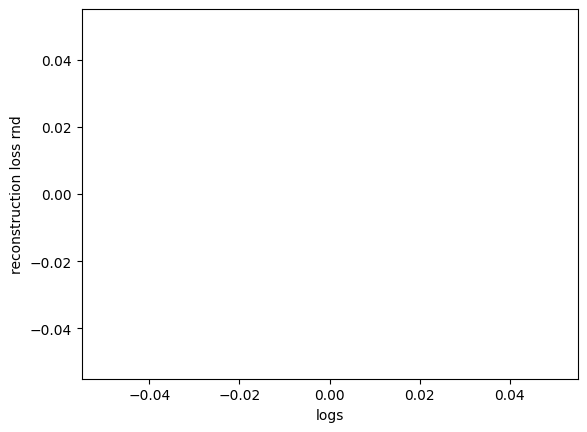

In [6]:
fig, ax = plt.subplots()
for key in data.keys():
    ax.plot(data[key], label=key)
    plt.xlabel('logs')
    plt.ylabel('size [Bytes]')
    plt.legend()

fig.savefig("data/size.png")

fig, ax = plt.subplots()
for key in times.keys():
    ax.plot(np.array(times[key][10:])*10**3, label=key)
    plt.xlabel('logs')
    plt.ylabel('time [ms]')
    plt.legend()

fig.savefig("data/time.png")

fig, ax = plt.subplots()
ax.plot(thresholds)
ax.plot(recostruction_loss)
plt.xlabel('logs')
plt.ylabel('reconstruction loss')

fig.savefig("data/reconstruction_loss.png")

fig, ax = plt.subplots()
ax.plot(thresholds_rnd)
ax.plot(recostruction_loss_rnd)
plt.xlabel('logs')
plt.ylabel('reconstruction loss rnd')

plt.savefig("data/reconstruction_loss_rnd.png")



plt.show()

In [ ]:
# z = tf.random.normal(shape=(1,60 ,30),dtype=tf.float32)
encode_token = val_ds.take(1).batch(1).as_numpy_iterator().next()

print(encode_token)


z = model.vae.encoder(tokenizer.preprocess(encode_token))[0]

tokens = model.vae.decode(z)

print((tokenizer.decode(tokens).numpy()))


In [ ]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    # plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=256,embedding_dim=128,max_len = max_len)


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

ds_val_pre = val_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

plot_label_clusters(model.vae, "cluster"+str(17),ds_val_pre.take(10000).batch(128))